In [1]:
from tqdm.notebook import tqdm
import pdb

In [3]:
#Astropy
import astropy
from astropy.io import fits
from astropy.table import Table

# emcee
import emcee
import corner

# Dlnpyutils
# from dlnpyutils import utils
from dlnpyutils.utils import bspline,mad

# dust_extinction
from dust_extinction.parameter_averages import CCM89,O94,F99,VCG04,GCC09,M14,F19,D22

# Matplotlib
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
matplotlib.rcParams.update({'font.size': 25})

#Numpy/Scipy
import numpy as np
import scipy
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.stats import binned_statistic

class Stellalogium():
    '''
    A class to calculate a star's extinction, age and Mass using PARSEC isochrones with 
    Gaia (E)DR3 and 2MASS photometry utilizing an MCMC
    '''
    
    def __init__(self,teff,logg,metallicity,photometry,distance,isochrones,ext_law='CCM89',rv=3.1):
        '''
        Inputs:
        ------
            teff:        2x1 array-like
                         Teff and error of star (example: np.array([teff,teff_err]))
                        
            logg:        2x1 array-like
                         Log(g) and error of star (example: np.array([logg,logg_err]))
                    
            metallicity: 2x2 array-like
                         first column is [M/H] and [Alpha/M] and the second column is the errors
                    
            photometry:  6x2 array-like
                         first column is BP, G, RP, J, H, and K and the second column is the errors
                        
            distance:    float
                         distance to star in pc
                    
            isochrones:  astropy Table 
                         PARSEC isochrone table
                        
            ext_law:     string, optional
                         extinction law to use. Default is CCM89.
                        
                         Available Extinction Laws: 
                         -------------------------

                         CCM89 - Cardelli, Clayton, & Mathis 1989
                         O94 - O'Donnell 1994
                         F99 - Fitzpatrick 1999
                         F04 - Fitzpatrick 2004
                         VCG04 - Valencic, Clayton, & Gordon 2004
                         GCC09 - Grodon, Cartledge, & Clayton 2009
                         M14 - Maiz Apellaniz et al 2014
                         F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                         D22 - Decleir et al. 2022
                        
            rv:          float, optional
                         Rv (=Av/E(B-V)) extinction law slope. Default is 3.1 
                         (required to be 3.1 if ext_law = 'F99')

        '''
        
        # Teff, log(g), Salaris [Fe/H]
        self.teff = teff
        self.logg = logg
        self.mh = np.array([metallicity[0,0],metallicity[0,1]])
        self.alpha_m = np.array([metallicity[1,0],metallicity[1,1]])
        self.salfeh = self.salaris_corrected_metallicity(self.mh,self.alpha_m)
        
        # Photometry and distance
        self.app_phot = photometry
        self.distmod = 5*np.log10(distance)-5
        
        # PARSEC isochrones
        self.labels = ['G_BPEDR3mag','GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']
        
        self.iso = isochrones[np.where(isochrones['MH']==self.closest(isochrones['MH'],self.salfeh))]
        
        self.uniq_ages = np.unique(self.iso['logAge'])
        age_idx = []
        for i in range(len(self.uniq_ages)):
            ages, = np.where(self.iso['logAge']==self.uniq_ages[i])
            age_idx.append(np.array([min(ages),max(ages)]))
        
        self.age_idx = np.asarray(age_idx)
        
        self.uniq_masses = np.unique(self.iso['Mass'])
        mass_idx = []
        for i in range(len(self.uniq_masses)):
            masses, = np.where(self.iso['Mass']==self.uniq_masses[i])
            mass_idx.append(np.array([min(masses),max(masses)]))
        
        self.mass_idx = np.asarray(mass_idx)
        
        # Effective Wavelengths of different passbands in units of microns
        self.rv = rv
        self.leff = np.array([0.5387,0.6419,0.7667,1.2345,1.6393,2.1757]) #BP, G, RP, J, H, K
        self.extlaw_coeff = self.extcoeff(law=ext_law,rv=rv)
        
        # Solar values
        self.lgteff_sun = np.log10(5773.) # +/- 16 K Asplund et al. 2021
        self.logg_sun = 4.4374 # +/- 0.0005 Gray D.F., 1992
        
    def salaris_corrected_metallicity(self,mh,alpha_m):
        '''
        Calculate the Salaris corrected metallicity according Salaris et al. 1993 with updated
        solar parameters from Asplund et al. 2021.
        
        Inputs:
        ------
            mh:         2x1 array-like
                        [M/H] and associated error
            
            alpha_m:    2x1 array-like
                        [Alpha/M] and associated error
                     
        Output:
        ------
            salfeh:     float
                        Salaris corrected metallicity
            
            salfeh_err: float 
                        Error in Salaris corrected metallicity
        '''
        
        salfeh = mh[0]+np.log10(0.659*(10**(alpha_m[0]))+0.341)
        salfeh_err = np.sqrt(mh[1]**2+((1-0.341/(0.659*(10**(alpha_m[0]))+0.341))*alpha_m[1])**2)
        
        return salfeh, salfeh_err
    
    #################
    ### Utilities ###
    #################
    
    def closest(self,data,value):
        '''
        Find nearest value in array to given value

        Inputs:
        ------
            data:  array-like
                   data to search through

            value: float or int
                   value of interest

        Output:
        ------
            close: float or int
                   value in data closest to given value
        '''
        
        data = np.asarray(data)
        
        return data[(np.abs(np.subtract(data,value))).argmin()]
    
    def neighbors(self,data,value):
        '''
        Find values of two elements closest to the given value

        Inputs:
        ------
            data:   array-like
                    data to search through

            value:  float or int
                    value of interest

        Output:
        ------
            close1: float or int
                    closest value under the given value

            close2: float or int
                    closest value over the given value
        '''
    
        data = np.asarray(data)
        close1 = data[(np.abs(np.subtract(data,value))).argmin()]
        data = data[np.where(data!=close1)]
        close2 = data[(np.abs(np.subtract(data,value))).argmin()]
    
        return close1,close2
    
    
    ###################
    ### Extinctions ###
    ###################
    
    def extcoeff(self,law='CCM89',rv=3.1):
        '''
        Calculate the relative extincion law coefficients for a given wavelength relative to the 
        BP, G, RP, J, H, K or user defined band

        Input:
        -----
            rv:         float
                        Rv (=Av/E(B-V)) extinction law slope. Default is 3.1
        
            law:        str
                        extinction law to use

                        Available Extinction Laws: 
                        -------------------------

                        CCM89 - Cardelli, Clayton, & Mathis 1989
                        O94 - O'Donnell 1994
                        F99 - Fitzpatrick 1999
                        F04 - Fitzpatrick 2004
                        VCG04 - Valencic, Clayton, & Gordon 2004
                        GCC09 - Grodon, Cartledge, & Clayton 2009
                        M14 - Maiz Apellaniz et al 2014
                        F19 - Fitzpatrick, Massa, Gordon, Bohlin & Clayton 2019
                        D22 - Decleir et al. 2022

        Output:
        ------
            ext_coeff:  float
                        calculated extinction coefficients for the BP, G, RP, J, H, and K bands 
                        relative to the Gaia G band

        '''

        leff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757}

        # select the extinction model
        if law == 'CCM89':
            ext_model = CCM89(Rv=rv)

        elif law == 'O94':
            ext_model = O94(Rv=rv)

        elif law == 'F99':
            ext_model = F99(Rv=rv)

        elif law == 'F04':
            ext_model = F04(Rv=rv)

        elif law == 'VCG04':
            ext_model = VCG04(Rv=rv)

        elif law == 'GCC09':
            ext_model = GCC09(Rv=rv)

        elif law == 'M14':
            ext_model = M14(Rv=rv)

        elif law == 'F19':
            ext_model = F19(Rv=rv)

        elif law == 'D22':
            ext_model = D22(Rv=rv)   

        # Calculate the relative extinction coefficient
        ext_coeff_array = ext_model(np.reciprocal(self.leff*u.micron))

        return ext_coeff_array
    
    def initial_a_g(self):
        '''
        Calulate the extinctions for the BP, G, RP, J, H, and K bands
        
        Output:
        ------
            ext: 6x2 array
                 first column is the extinction values and the second is the errors
            
        '''
        
        # isochrone magnitude labels
        color_labels = np.array([['G_BPEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag','GEDR3mag'],
                                 ['GEDR3mag','G_RPEDR3mag','Jmag','Hmag','Ksmag']]).T
        
        # pick isochrone points with temperatures within 200 K of the star's Teff
        teffcut = np.where((self.iso['logTe']<np.log10(self.teff+200.))&
                           (self.iso['logTe']>np.log10(self.teff-200.)))
        iso_ = self.iso[teffcut]
        
        # check to make sure teff of star is in range of the isochrone
        if np.size(np.squeeze(teffcut))==0:
            self.a_g_init = 999999.0
            return 999999.0
    
        # get colors and errors
        obs_colors = np.delete(self.phot-self.phot[1],1)
        obs_colors[1:] = -1*obs_colors[1:]
        obs_colors_err = np.delete(np.sqrt(self.phot_err**2+self.phot_err[1]**2),1)
        
        # create "reddening" vector (slightly modified from the normal definition)
        red_vec = np.delete(1-self.extlaw_coeff/self.extlaw_coeff[1],1)
        red_vec[0] = -1*red_vec[0]
        
        ext_vec = self.extlaw_coeff/self.extlaw_coeff[1]
        
        # calculate the intrinsic colors using a b-spline
        bspline_vec = 999999.0*np.ones(5)
        bspline_vec_deriv = 999999.0*np.ones(5)
        
        for i in range(5):
            try:
                # Interpolate the color-Teff relation using a b-spline
                color = (iso_[color_labels[i,0]]-iso_[color_labels[i,1]])
                logTe = iso_['logTe']

                bspl = bspline(logTe,color)
                bspline_vec[i] = bspl(np.log10(self.teff))
                bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
            except:
                try:
                    bspl = bspline(logTe,color,extrapolate=True)
                    bspline_vec[i] = bspl(np.log10(self.teff))
                    bspline_vec_deriv[i] = bspl.derivative()(np.log10(self.teff))
                
                except:
                    bspline_vec[i] = 999999.0
                    bspline_vec_deriv[i] = 999999.0
                
        # calculate the extinctions and errors
        color_diff = obs_colors-bspline_vec
        
        bspl_errs = np.abs((bspline_vec_deriv*self.teff_err)/(self.teff*np.log(10)))
        color_diff_err = np.sqrt(obs_colors_err**2+bspl_errs**2)
        
        # find bad values this should take care of bad values from the spline
        neg_cut = np.where(color_diff>0)
        
        # if all bad return bad values
        if np.size(np.squeeze(neg_cut))==0:
            self.a_g_init = 999999.0
            return 999999.0
        
        # calculate the extinction value
        a_g_init = np.dot(red_vec[neg_cut],color_diff[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        a_g_err = np.dot(red_vec[neg_cut],color_diff_err[neg_cut])/np.linalg.norm(red_vec[neg_cut])**2
        
        self.a_g_int = np.array(a_g_init,a_g_init_err)
        
        return a_g_init, a_g_init_err
    
    ##################
    ### Magnitudes ###
    ##################
    
    def teff_2_appmags(self,teff,age,verbose=False):
        '''
        Calculate the expected apparent magnitude of a star
        
        Inputs:
        ------
            teff:     float
                      Teff of star 
                      
            age:      float
                      age of star
        
        Output:
        ------
            calc_mag: 6x2 array 
                      expected intrinsic magnitude for the given temperature
        '''
        
        #Some calcualtions to set things up
        lgteff = np.log10(teff)
        
        extincts = self.ext[:,0]
        
        lgage = np.log10(age*10**9)
        
        # Figure out if age is actually in the ages given in the isochrone table
        if lgage in self.uniq_ages:
            
            ### pick out a single isochrone 
            aidx, = np.where(self.uniq_ages==lgage)
            iso_ = self.iso[self.age_idx[int(aidx)][0]:self.age_idx[int(aidx)][1]]
            
            if lgteff < min(iso_['logTe']) or lgteff > max(iso_['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a spline to get the apparent mags
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl = bspline(iso_['logTe'],iso_[self.labels[i]])
                calc_mags[i] = mag_spl(lgteff)+self.distmod+extincts[i]
                
            return calc_mags
                
#             lgg_spl = utils.bspline(iso_['logTe'],iso_['logg'])
#             calc_logg = lgg_spl(lgteff)
                
#             return np.append(calc_mags, calc_logg)    
            
            #return calc_mags
            
        else:
            lgage_lo,lgage_hi = self.neighbors(self.uniq_ages,lgage)
            if verbose:
                print('[age_lo,age_hi]: ',[10**lgage_lo/10**9,10**lgage_hi/10**9])
            
            ### Pick out single isochrones
        
            # younger
            aidx_lo, = np.where(self.uniq_ages==lgage_lo)
            iso_lo = self.iso[self.age_idx[int(aidx_lo)][0]:self.age_idx[int(aidx_lo)][1]]
            
            # older
            aidx_hi, = np.where(self.uniq_ages==lgage_hi)
            iso_hi = self.iso[self.age_idx[int(aidx_hi)][0]:self.age_idx[int(aidx_hi)][1]]
            
            ### Temperature Check
            if lgteff < min(iso_lo['logTe']) or lgteff > max(iso_lo['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            if lgteff < min(iso_hi['logTe']) or lgteff > max(iso_hi['logTe']):
                return np.array([999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0, 999999.0])
            
            ### use a b-spline to get the apparent mags
            age_lo = 10**lgage_lo/10**9
            age_hi = 10**lgage_hi/10**9
            calc_mags = 999999.0*np.ones(6)
            for i in range(6):
                mag_spl_lo = bspline(iso_lo['logTe'],iso_lo[self.labels[i]]) 
                mag_spl_hi = bspline(iso_hi['logTe'],iso_hi[self.labels[i]])
                age_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                                 [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
                calc_mags[i] = age_spl_interp(age)+self.distmod+extincts[i]
                
            lgg_spl_lo = bspline(iso_lo['logTe'],iso_lo['logg'])
            lgg_spl_hi = bspline(iso_hi['logTe'],iso_hi['logg'])
            
            lgg_spl_interp = np.poly1d(np.squeeze(np.polyfit([age_lo,age_hi],
                                                             [mag_spl_lo(lgteff),mag_spl_hi(lgteff)],1)))
            
            calc_logg = lgg_spl_interp(age)

            return np.append(calc_mags, calc_logg)
        
    ############
    ### MCMC ###
    ############
    
    def lnL(self,theta,teff,appmags,appmags_err):
        '''
        The log likelihood function used to get the extinction and age
        
        Inputs:
        ------
            theta:       2x1 array-like
                         the G band extinction and age of a star
            
            teff:        float
                         temperature 
            
            appmags:     6x1 array-like
                         apparent magnitudes in the BP, G, RP, J, H, Ks bands
            
            appmags_err: 6x1 array-like
                         error in the apparent magnitudes in the BP, G, RP, J, H, Ks bands
            
        '''
        
        a_g, age = theta
        model = self.teff_2_appmags(teff,a_g,age)
        return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(yerr**2))
    
    def lnprior(self,theta):
        '''
        The priors for both the extinction and age
        
        Inputs:
        ------
            theta: 2x1 array-like
                   the G band extinction and age of a star
        '''
        
        a_g, age = theta
        if 0.0 < a_g < 0.5 and 0.0 < age < 17.0:
            return 0.0
        return -np.inf
    
    def lnprobability(theta,teff,appmags,appmags_err):
        '''
        The log likelihood function used to get the extinction and age
        
        Inputs:
        ------
            theta:       2x1 array-like
                         the G band extinction and age of a star
            
            teff:        float
                         temperature 
            
            appmags:     6x1 array-like
                         apparent magnitudes in the BP, G, RP, J, H, Ks bands
            
            appmags_err: 6x1 array-like
                         error in the apparent magnitudes in the BP, G, RP, J, H, Ks bands
            
        '''
        
        lp = lnprior(theta)
        if not np.isfinite(lp):
            return -np.inf
        return lp + lnL(theta,teff,appmags,appmags_err)
    
    def get_a_g_age(self,N=100,seed=None):
        '''
        Run an MCMC to get the extinctions and age with associate error
        '''
        
        if seed is not None:
            np.random.seed(seed)
        
        ### Initial Guesses
        
        teffs = np.random.normal(self.teff, self.teff_err, 100)
        
        
        self.extinction()
        
        ### Run the MCMC
        
        return a_g, a_g_err, age, age_err

In [40]:
def closest(data,value):
    '''
    Find nearest value in array to given value

    Inputs:
    ------
        data:  array-like
               data to search through

        value: float or int
               value of interest

    Output:
    ------
        close: float or int
               value in data closest to given value
    '''

    data = np.asarray(data)

    return data[(np.abs(np.subtract(data,value))).argmin()]

In [37]:
np.random.normal(1., 0.1, 6)

array([0.93971649, 0.90207835, 1.03778043, 0.93295931, 1.03196973,
       0.89909038])

In [33]:
np.random.seed(42)
nll = lambda *args: -log_likelihood(*args) # negative log likelihood
initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3) # initial guesses
soln = minimize(nll, initial, args=(x, y, yerr)) # minimize? I thought this was MLE
m_ml, b_ml, log_f_ml = soln.x

# intial positions of walkers for all three parameters
pos = soln.x + 1e-4 * np.random.randn(50, 3) 
nwalkers, ndim = pos.shape

# sample the distribution an marginalize
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(x, y, yerr)
)
sampler.run_mcmc(pos, 5000, progress=True); # run for 5000 steps

(6,)

# PARSEC

In [38]:
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec36_DR2_EDR3.fits')
massive = Table(massive[np.where(massive['label']==3.0)])
massive = massive[np.argsort(massive['logAge'])]
massive = massive['MH','Mass','int_IMF','logAge','logTe','logg','GEDR3mag','G_BPEDR3mag','G_RPEDR3mag',
                  'Jmag','Hmag','Ksmag']
# I noticed that there's some weird points marked as RGB, so I cut those out with
cut = np.poly1d(np.polyfit([4600,5400],[0.5,2],1))
massive = massive[np.where(massive['logg']>cut(10**massive['logTe']))]

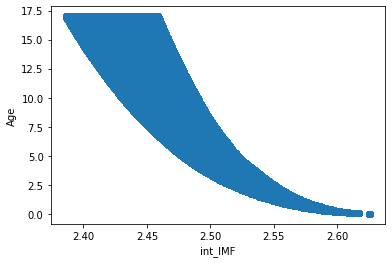

In [41]:
singfeh = massive[np.where(massive['MH']==closest(massive['MH'],-0.5))]

plt.scatter(massive['int_IMF'],10**massive['logAge']/10**9)
plt.xlabel(r'int_IMF')
plt.ylabel(r'Age')
plt.show()

(array([11.57599869, 10.5621503 ,  8.37004567,  6.52783466,  4.62871324,
         3.29869591,  1.95603183,  0.57331967,  0.27401308,  0.13279095]),
 array([2.41703844, 2.43791544, 2.45879245, 2.47966945, 2.50054646,
        2.52142346, 2.54230046, 2.56317747, 2.58405447, 2.60493147,
        2.62580848]),
 <BarContainer object of 10 artists>)

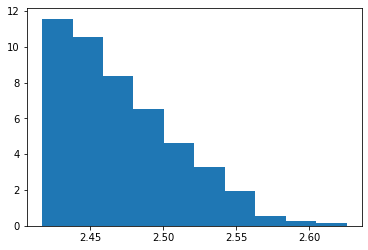

In [43]:
plt.hist(singfeh['int_IMF'],density=True)

# APOKASC

<ipython-input-31-e3a3ff7f88c0>:6: RuntimeWarning: invalid value encountered in sqrt
  apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)


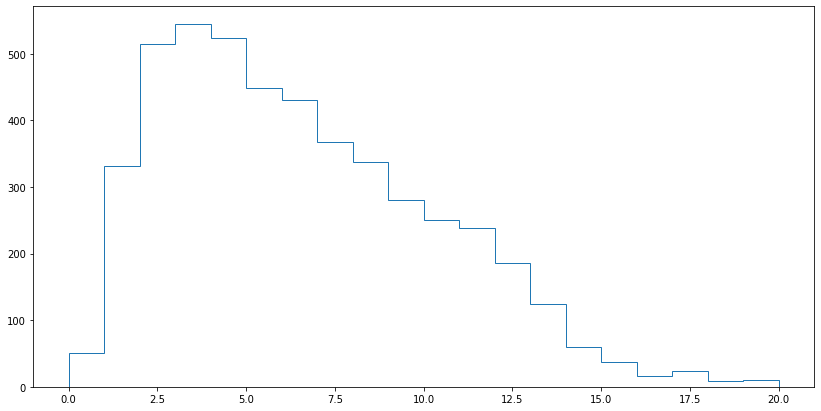

In [31]:
# apo = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/apogee_library_dr17_rev1.fits')
dr17 = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-dr17-synspec_rev1.fits.gz')

# Calculate [alpha/Fe]
apoafe = dr17['ALPHA_M']+dr17['M_H']-dr17['FE_H']
apoafe_err = np.sqrt(dr17['ALPHA_M']**2+dr17['M_H']**2-dr17['FE_H']**2)

# 0.659, 0.341 from Asplund et al 2021.
salfeh = dr17['FE_H']+np.log10(0.659*(10**(apoafe))+0.341)
salfeh_err = np.sqrt(dr17['FE_H_ERR']**2+((1-0.341/(0.659*(10**(apoafe_err))+0.341))*apoafe)**2)

k674 = fits.getdata('/Users/joshuapovick/Desktop/Research/APOKASC/APOKASC_cat_v6.7.4.fits.gz')

# xmatch APOKASC with DR17
_, k674idx, dr17idx = np.intersect1d(k674['2MASS_ID'],dr17['APOGEE_ID'],return_indices=True)

k674 = k674[k674idx]
kdr17 = dr17[dr17idx]
apoafe = apoafe[dr17idx]
apoafe_err = apoafe_err[dr17idx]
salfeh = salfeh[dr17idx]
salfeh_err = salfeh_err[dr17idx]

# Select RGB stars
ageevs = np.where((k674['A3P_AGEMOD_JT']>-10.)&(k674['APOKASC3_CONS_EVSTATES']==1.0)&np.isfinite(kdr17['fe_h']))

k674 = k674[ageevs]
kdr17 = kdr17[ageevs]
apoafe = apoafe[ageevs]
apoafe_err = apoafe_err[ageevs]
salfeh = salfeh[ageevs]
salfeh_err = salfeh_err[ageevs]

good, = np.where((kdr17['SNR']>50) & (kdr17['TELESCOPE']!='apo1m') & np.isfinite(kdr17['TEFF']) &
                 np.isfinite(kdr17['LOGG']) & ((kdr17['STARFLAG'] & 2**9)<=0) &
                 ((kdr17['ASPCAPFLAG'] & 2**24)<=0))

k674 = k674[good]
kdr17 = kdr17[good]
apoafe = apoafe[good]
apoafe_err = apoafe_err[good]
salfeh = salfeh[good]
salfeh_err = salfeh_err[good]

plt.figure(figsize=[14,7])
plt.hist(k674['A3P_AGEMOD_JT'],histtype='step',range=(0,20),bins=20)
plt.show()